# Toy example for Data Assimilation

The aim of data assimilation is to reduce the uncertainties in models with the help of observations.
In this notebook the Kalman Filter and the 4D-Var methods are compared. First with a linear model and then with the classical [Lorenz 1969 model](https://doi.org/10.1175/1520-0469%281963%29020%3C0130:DNF%3E2.0.CO;2).

In [1]:
using DataAssim
using LinearAlgebra
using PyPlot
using Random
using Test

# State vector

$\newcommand{\e}[1]{{\bf \color{red}{#1}}}$
$\newcommand{\tindex}{k}$
$\renewcommand{\vec}[1] {{\mathbf #1}}$
$\renewcommand{\mat}[1] {{\mathbf #1}}$

The state vector $\vec x_\tindex$ containing all _prognostic_ variables at time $t_\tindex$ (time of the $\tindex$-th time step).

# Model
A model `‚Ñ≥` need to define the following operations:

* a foreward step: `‚Ñ≥(t,x,Œ∑)`
* tangent linear model: `tgl(‚Ñ≥,t,x,dx)`
* adjoint model: `adj(‚Ñ≥,t,x,dx2)`

Œ∑ is random noise for a stochastic model or zero for a detministic model.

In [2]:
function check(‚Ñ≥::AbstractModel,n,t = 0,œµ = 1e-5)
    dx = randn(n)
    x = randn(n)
    dx2 = randn(n)

    @test (‚Ñ≥(t,x + œµ*dx) - ‚Ñ≥(t,x - œµ*dx)) / (2*œµ)  ‚âà tgl(‚Ñ≥,t,x,dx) atol=10*œµ^2
    @test dx2 ‚ãÖ tgl(‚Ñ≥,t,x,dx) ‚âà adj(‚Ñ≥,t,x,dx2) ‚ãÖ dx   atol=1e-7

    dX = randn(n,3)
    MdX = tgl(‚Ñ≥,t,x,dX)
    @test tgl(‚Ñ≥,t,x,dX[:,1]) ‚âà MdX[:,1]
end

check (generic function with 3 methods)

Simple model can be defined using matrix `ModelMatrix(M)`

$$
\vec x_{\tindex+1} = \mat M \; \vec x_\tindex 
$$

In [3]:
‚Ñ≥ = ModelMatrix(2*I)

x = randn(4)
@test ‚Ñ≥(0,x) ‚âà 2*x
@test tgl(‚Ñ≥,0,0,x) ‚âà 2*x
@test adj(‚Ñ≥,0,0,x) ‚âà 2*x
check(‚Ñ≥,4)

Test Passed

Or using a operator $\cal M$, potentially non-linear:


$$
\vec x_{\tindex+1} = \cal M(t_\tindex, \vec x_\tindex)
$$

In this case, the tagent linear and adjoint model have to be provided too (or derived from automatic differential tools)

In [4]:
?ModelFun

search: ModelFun



```
‚Ñ≥ = ModelFun(nonlinear_forecast,tangent_linear_model,adjoint_model)
```

Model defined by the functions `nonlinear_forecast`,`tangent_linear_model` and  `adjoint_model`.


In [5]:
‚Ñ≥ = ModelFun((t,x,Œ∑) -> 2*x,(t,x,dx) -> 2*dx,(t,x,dx) -> 2*dx)

x = randn(4)
@test ‚Ñ≥(0,x) ‚âà 2*x
@test tgl(‚Ñ≥,0,0,x) ‚âà 2*x
@test adj(‚Ñ≥,0,0,x) ‚âà 2*x
check(‚Ñ≥,4)

Test Passed

# Kalman Filter

In [6]:
# state size x
n = 2;

# number of observation per time instance
m = 1;

# observation operator
H = [1 0];
ùìó = ModelMatrix(H)

# initial condition
xi = [1; 1];

# error covariance of the initial condition
Pi = Matrix(I,n,n)

# error covariance of the observations
R = 0.1 * Matrix(I,m,m)

1√ó1 Matrix{Float64}:
 0.1

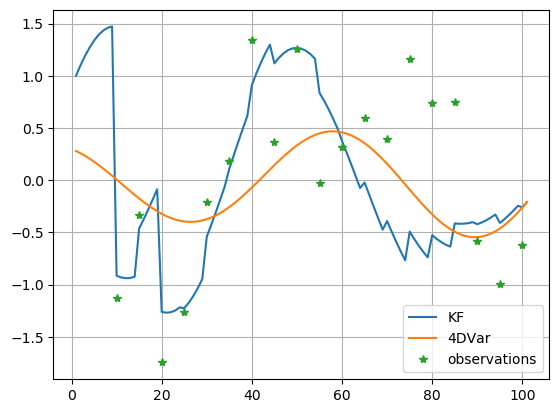

In [7]:
‚Ñ≥ = ModelMatrix([1 0.1; -0.1 1])

nmax = 100;
no = 10:5:nmax
yo = randn(m,length(no))


xai, = fourDVar(xi,Pi,‚Ñ≥,yo,R,H,nmax,no);
Q = zeros(size(Pi))
xa, = FreeRun(‚Ñ≥,xai,Q,H,nmax,no)

#ùìó
#ùìú
xa3, = KalmanFilter(xi,Pi,‚Ñ≥,Q,yo,R,H,nmax,no);
# should be ~0
@test xa[:,end] ‚âà xa3[:,end]  atol=1e-5
time = 1:nmax+1

plot(time,xa3[1,:],label="KF")
plot(time,xa[1,:],label="4DVar")
plot(time[no],yo[1,:],"*";label="observations")
legend()
grid("on")

In [8]:
size(xa)

(2, 101)

In [9]:
?fourDVar

search: fourDVar



```
x,J = fourDVar(
        xi,Pi,‚Ñ≥,yo,R,H,nmax,no;
        innerloops = 10,
        outerloops = 2,
        tol = 1e-5)
```

Incremental 4D-Var with the model `‚Ñ≥` and `nmax` time-steps starting at the initial condition `xi` and error covariance `Pi` with the specified numbers of inner  and outer loops. Observations `yo` (and error covariance `R`) at the time steps given in `no` are assimilated with the observation operator `H`.


# Lorenz-63 Model

In [10]:
?Lorenz63Model

search: Lorenz63Model



```
‚Ñ≥ = Lorenz63Model(dt,œÉ=10.,Œ≤ = 8/3.,œÅ = 28.)
```

Lorenz, 1963 model[1] integrated with a 2nd order Runge-Kutta scheme.

[1] https://doi.org/10.1175/1520-0469(1963)020%3C0130:DNF%3E2.0.CO;2


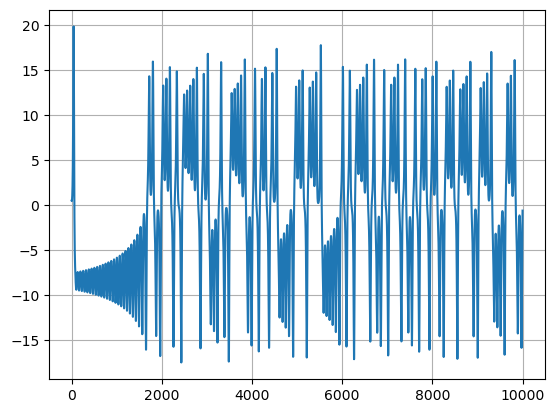

In [11]:
Random.seed!(12343)
‚Ñ≥ = Lorenz63Model(0.01)

x = zeros(3,10000)
x[:,1] = randn(3)

for k = 1:size(x,2)-1
    x[:,k+1] = ‚Ñ≥(k,x[:,k])
end

plot(x[1,:])
grid("on");

In [12]:
‚Ñ≥ = Lorenz63Model(0.05)

nmax = 20;
no = 5:nmax;
n = 3;
sigma=10;
beta = 8/3;
rho = 28;
dt = 0.02;

xit = [5.; 0.; 0.];
H = [1 0 0];
m = size(H,1)
Pi = Matrix(3*I,n,n)
Q = zeros(n,n);
R = ones(m,m)

1√ó1 Matrix{Float64}:
 1.0

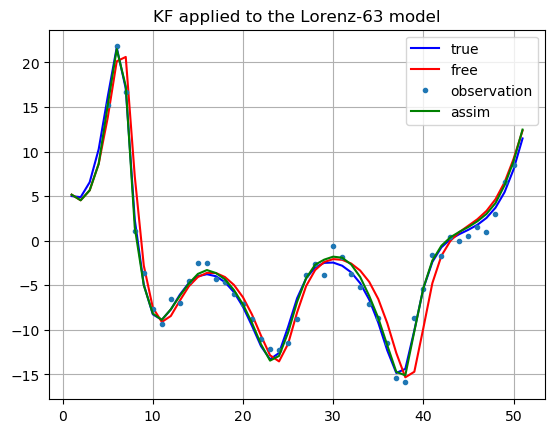

In [13]:
function LorenzTest(nmax,method)
    no = 5:nmax
    xt,xfree,xa,yt,yo,diag_ = TwinExperiment(‚Ñ≥,xit,Pi,Q,R,H,nmax,no,method)

    time = 1:nmax+1
    plot(time,xt[1,:],"b",label = "true")
    plot(time,xfree[1,:],"r",label = "free")
    plot(time[no],yo[1,:],".",label = "observation")
    plot(time,xa[1,:],"g", label = "assim")
    legend()
    title("$method applied to the Lorenz-63 model")
    grid("on")
end

nmax = 50;
method = "KF";
LorenzTest(nmax,method);

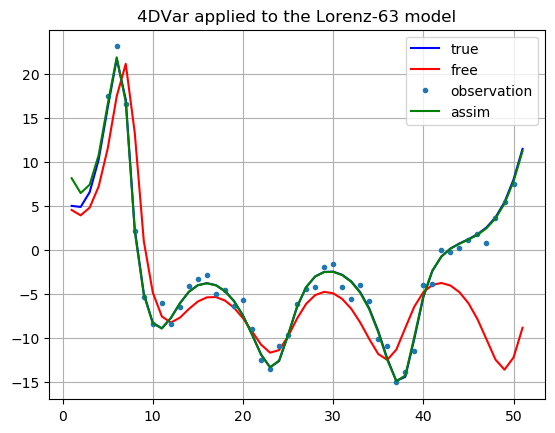

In [14]:
nmax = 50;
method = "4DVar";
LorenzTest(nmax,method);

Note for longer time integration, the 4D-Var method can no longer track the observations.
The minimization algorithm is trapped in a local minima.

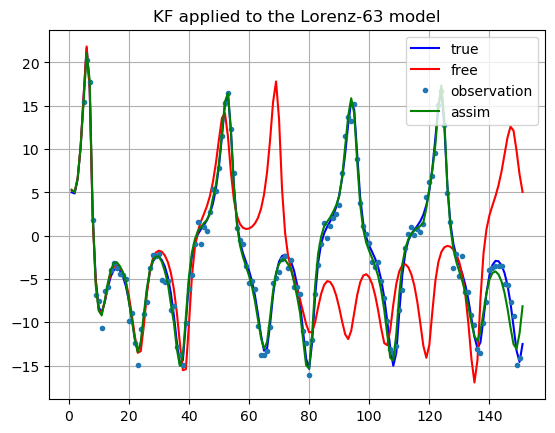

In [15]:
nmax = 150;
method = "KF";
LorenzTest(nmax,method);

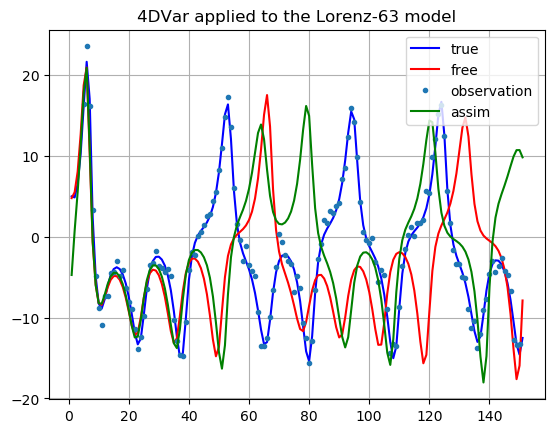

In [16]:
nmax = 150;
method = "4DVar";
LorenzTest(nmax,method);